# **Particle identification for the hadronic calorimeter imaging prototype**

### **CALICE AHCAL prototype**

The prototype has been installed in the test beam for data taking at the CERN SPS. During two periods in May and in June 2018, 
events with muon tracks, as well as electron and pion showers in the energy ranges 10 – 100 GeV and 10 – 200 GeV, respectively, 
have been recorded. 

In this seminar, data corresponding to simulation of [a highly granular SiPM-on-tile calorimeter prototype](https://arxiv.org/pdf/1808.09281.pdf) is used.

### **Setup**
38 active layers equipped with 24x24 scindilator plates ${30x30x2 mm^3}$ each equipped with individual SiPM readout. 

<img src="images/setup_1.jpg" alt="drawing" width="800"/>

Active layers are inserted in between ${15 mm}$ steel plates:

<img src="images/setup_2.jpg" alt="drawing" width="800"/>

### **Particle identification**

<img src="images/pid.jpg" alt="drawing" width="600"/>

If one wants to investigate detector response on particles with given properties, event selection is needed. The goal of the seminar is to construct such event selection model for 10GeV particles, which would be able to classify them according to their type using (almost) raw simulated hits in calorimeter layers.

We will use Boosted Decision Tree model for that purpose and specifically [LightGBM](https://lightgbm.readthedocs.io/en/latest/) implementation of it as an example. However, you might want to try other other popular boosting libraries: [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [CatBoost](https://catboost.ai/docs/).

In [185]:
import uproot
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

In [186]:
plt.rcParams.update({
'font.size': 20,
'figure.figsize': (11, 10),
'axes.grid': True,
'grid.linestyle': '-',
'grid.alpha': 0.2,
'lines.markersize': 5.0,
'xtick.minor.visible': True,
'xtick.direction': 'in',
'xtick.major.size': 20.0,
'xtick.minor.size': 10.0,
'xtick.top': True,
'ytick.minor.visible': True,
'ytick.direction': 'in',
'ytick.major.size': 20.0,
'ytick.minor.size': 10.0,
'ytick.right': True,
'errorbar.capsize': 0.0,
})

### **Data structure**
In the dataset we are going to use each entry corresponds to a single event, while each subentry represents one single hit. Hit positions `ahc\_hitX/Y/Z` in ${mm}$  - Z-axis is along beam direction - and corresponding energy deposition `ahc\_hitEnergy` in units of Minimum Ionising Particle (MIP) $\approx 0.5 \, \text{MeV}$ are also stored.

In [195]:
# Loading simulated data from the ROOT files to the Pandas dataframe
data = {}

variables = ['ahc_hitX','ahc_hitY','ahc_hitZ','ahc_hitEnergy','ahc_st']
data['Electron'] = uproot.open("/home/opv002/py_notes/ml-lpi/week2_trees/data/Reco_Run60973_e-_10GeV_QGSP_BERT_HP_AllEvents.root")["bigtree"].pandas.df(variables) # ~10k events
data['Pion']  = uproot.open("/home/opv002/py_notes/ml-lpi/week2_trees/data/Reco_Run60973_pi-_10GeV_QGSP_BERT_HP_AllEvents.root")["bigtree"].pandas.df(variables) # ~10k events
data['Muon']  = uproot.open("/home/opv002/py_notes/ml-lpi/week2_trees/data/Reco_Run60973_mu-_10GeV_QGSP_BERT_HP_AllEvents.root")["bigtree"].pandas.df(variables) # ~10k events

data['Electron']['ID'] = 0 # Labels for the BDT model (chosen arbitrary)
data['Pion']['ID'] = 1
data['Muon']['ID'] = 2

particletypes = ['Electron', 'Pion', 'Muon']

#### **Exercise 1**

* Plot several events (at least 5) for different particle types, explain the difference
* How would you describe this visible difference quantatively? Feel free to modify the code below.

In [188]:
# your answer here

print('Muons do not initiate the shower, just ionized line along the track.')
print('Electrons start compact and short e/m shower.')
print('Pions start wide and long hadronic shower.')
print('However sometimes pions go through without initiating of hadronic showers. Such events look muons.')

# data['Electron'].head()
# data['Pion'].head()
# data['Muon'].loc[0]['ahc_hitZ'].min()

Muons do not initiate the shower, just ionized line along the track.
Electrons start compact and short e/m shower.
Pions start wide and long hadronic shower.
However sometimes pions go through without initiating of hadronic showers. Such events look muons.


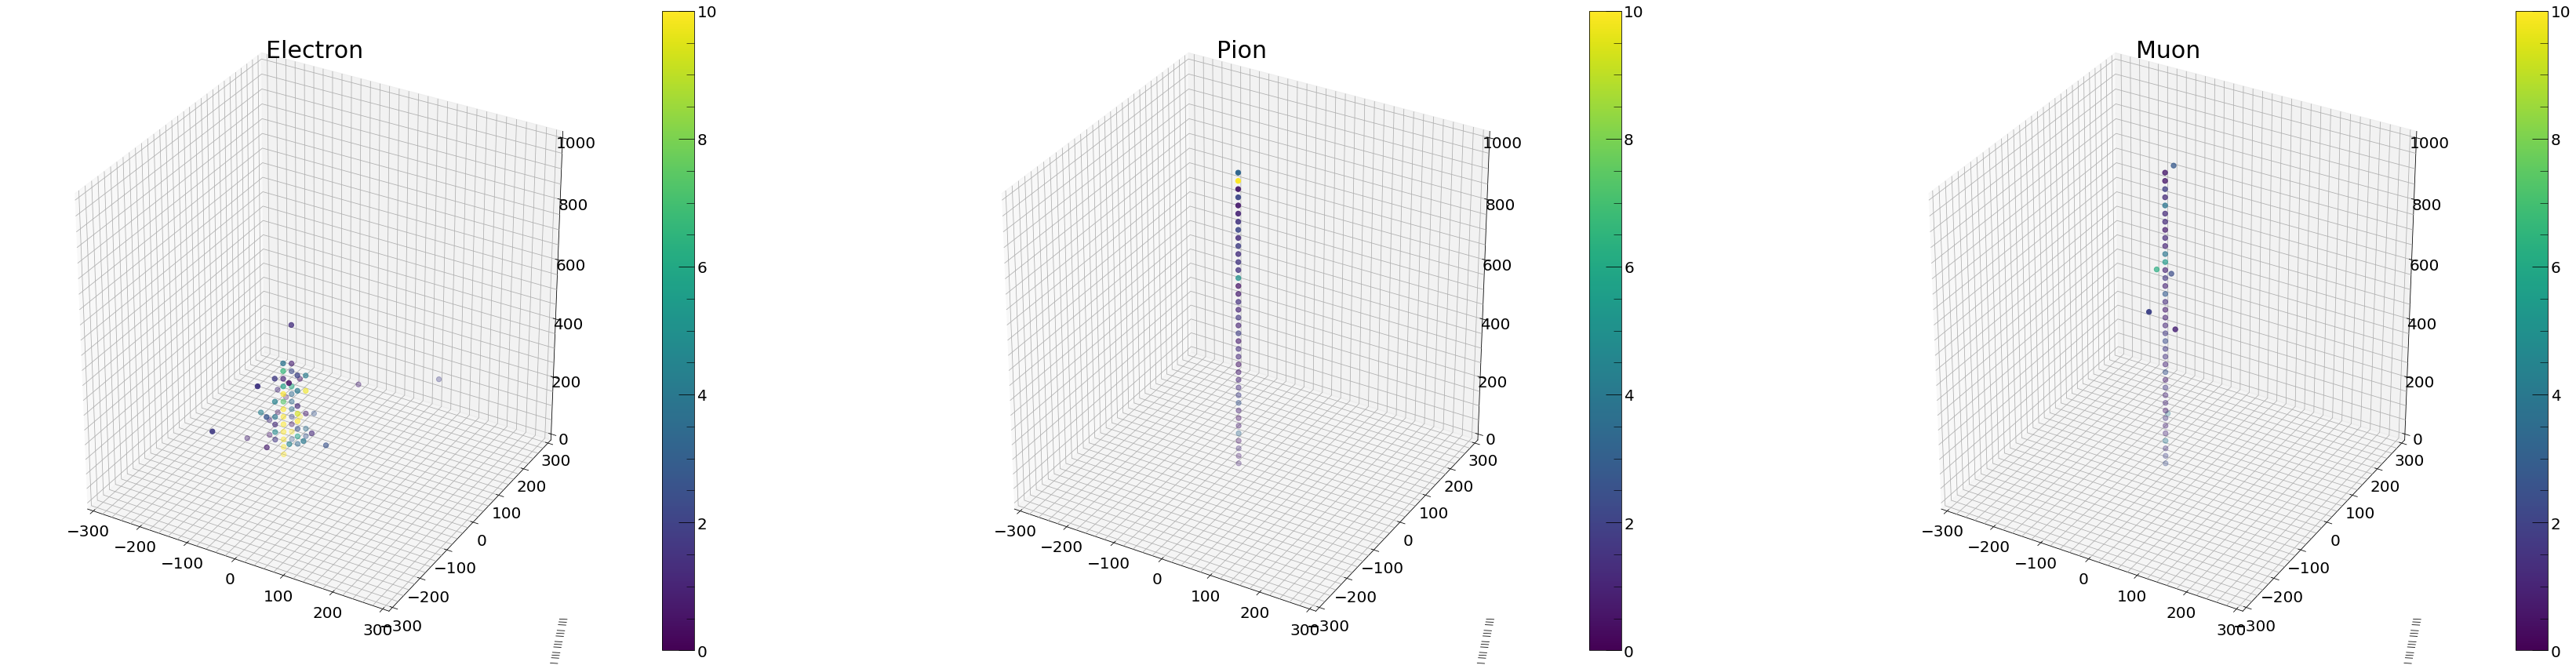

In [189]:
evt = 4
fig = plt.figure(figsize=[60,15])
for k in range(len(particletypes)):
    ax = fig.add_subplot(1, 3, k+1, projection='3d')
    ax.set_xlim3d(-300, 300)
    ax.set_ylim3d(-300, 300)
    ax.set_zlim3d(0,1000)
    ax.set_title(particletypes[k], fontsize=30)
    im = ax.scatter(data[particletypes[k]].loc[evt].ahc_hitX, data[particletypes[k]].loc[evt].ahc_hitY, data[particletypes[k]].loc[evt].ahc_hitZ, \
                  s=40, c=data[particletypes[k]].loc[evt].ahc_hitEnergy, depthshade=True,  cmap='viridis', vmin=0, vmax=10)
    fig.colorbar(im)
plt.show()

Or interactive mode:

In [191]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

evt = 10

fig = make_subplots(rows=1, cols=3,
                    specs=[[{'type': 'scene'}, {'type': 'scene'},  {'type': 'scene'}],
                          ],
                    subplot_titles=particletypes,
                    horizontal_spacing = 0.15
                   )

for i, particle_type in enumerate(particletypes, start=1):
    x = data[particle_type].loc[evt].ahc_hitX
    y = data[particle_type].loc[evt].ahc_hitY
    z = data[particle_type].loc[evt].ahc_hitZ
    e = data[particle_type].loc[evt].ahc_hitEnergy
    colorbar = dict(title = 'Hit energy deposit,\n [MIP]', len=0.75,) # x = ..., y = ...
    showscale = [False, False, True]
    
    fig.add_trace(
        go.Scatter3d(
        name=particle_type,
        x=x,
        y=y,
        z=z,
#         labels=dict(x="x, mm", y="y, mm", z="z, mm"),
        mode='markers',
        marker=dict(
            size=4,
            color=e,   
            cmin=0, cmax=20,
            colorscale='Viridis',  
            colorbar = colorbar,        
            opacity=1.,
            showscale=showscale[i-1]
        ),   
    ),
        row=1, col=i)

scenedict = dict(
            xaxis = dict(nticks=10, range=[-300,300], title = 'x, mm'),
            yaxis = dict(nticks=10, range=[-300,300], title = 'y, mm'),
            zaxis = dict(nticks=10, range=[0,1000], title = 'z, mm'),
            aspectratio=dict(x=0.6, y=0.6, z=1),
                    )
    
fig.update_layout(
        scene1 = scenedict,
        scene2 = scenedict,
        scene3 = scenedict,
)

fig.update_xaxes(title_text='x, mm')

fig.update_layout(
    title_text='Event display',
    height=800,
    width=1600,
    showlegend=False,
)


fig.show()

### **Some theory (in a very nutshell)**

Energy depositions of electromagnetic and hadronic showers are described by material-dependent parameters - so called [radiation- and nuclear interaction lengths](http://www.physics.rutgers.edu/~evahal/talks/tasi09/TASI_day3_school.pdf).  

In case of steel absorber, radiation lenth ${X_0}$ is ${O(1)}$ is less than nuclear interaction length ${\lambda_n}$ which, for example, leads to the fact that electromagnetic showers in the AHCAL start to shower much earlier than hadronic ones.

#### **Exercise 2**

* Can you draw any other conclusions from this?

In [39]:
# # your answer here

Z_min_dict = {}

for ptype in particletypes:
    Z_min_dict[ptype] = np.zeros(data[ptype].unstack().shape[0]+1)
    print(ptype)
    for event in data[ptype].index.get_level_values('entry').unique():
        Z_min_dict[ptype][event] = data[ptype].iloc[event]['ahc_hitZ'].min()

Electron
Pion
Muon


In [101]:
grouped_byZ = data['Pion'].loc[0].groupby('ahc_hitZ').agg({'ahc_hitX': lambda x: x.max() - x.min(),
                                                           'ahc_hitY': lambda y: y.max() - н.min()})

grouped_byZ['width'] = grouped_byZ['ahc_hitX'] + grouped_byZ['ahc_hitY']
# grouped_byZ

In [97]:
data_withLength = data['Pion'].loc[0].copy()
data_withLength['Zlenght'] = data['Pion'].loc[0]['ahc_hitZ'].max() - data['Pion'].loc[0]['ahc_hitZ'].min()
data_withLength

,ahc_hitX,ahc_hitY,ahc_hitZ,ahc_hitEnergy,ahc_st,ID,Zlenght
subentry,,,,,,,
0,-285.0,15.0,22.050001,0.688722,2,1,628.800049
1,-45.0,15.0,22.050001,0.970859,2,1,628.800049
2,-15.0,-15.0,22.050001,18.425146,2,1,628.800049
3,-15.0,-45.0,22.050001,24.879398,2,1,628.800049
4,45.0,-45.0,22.050001,5.331182,2,1,628.800049
...,...,...,...,...,...,...,...
87,-195.0,-45.0,441.250000,0.665775,2,1,628.800049
88,-45.0,-105.0,650.850037,3.007306,2,1,628.800049
89,225.0,15.0,650.850037,0.995927,2,1,628.800049


## ---------------------------------------------- TESTS ----------------------------------------------

In [234]:
data_copy = {}
data_reset = {}
data_groupedby_entry = {}
data_concatendated = {}
for ptype in particletypes:
    data_copy[ptype] = data[ptype].copy()
    data_reset[ptype] = data[ptype].copy()
    data_reset[ptype].reset_index(inplace=True)
    data_groupedby_entry[ptype] = data_reset[ptype].groupby('entry').agg({'ahc_hitX': lambda x: x.max() - x.min(),
                                                                          'ahc_hitY': lambda y: y.max() - y.min(),
                                                                          'ahc_hitZ': lambda z: z.max() - z.min(),
                                                                          'entry': 'mean'})
    data_groupedby_entry[ptype]['width'] = data_groupedby_entry[ptype]['ahc_hitX'] + data_groupedby_entry[ptype]['ahc_hitY']
    data_groupedby_entry[ptype]['length'] = data_groupedby_entry[ptype]['ahc_hitZ']
    data_groupedby_entry[ptype] = data_groupedby_entry[ptype].drop(columns=['ahc_hitX', 'ahc_hitY', 'ahc_hitZ'])
#     data_concatendated[ptype] = pd.concat([data_copy[ptype], data_groupedby_entry[ptype]])

In [246]:
for ptype in particletypes:
    for event in range(0,10):
        
#         print(ptype, event)

SyntaxError: unexpected EOF while parsing (<ipython-input-246-cc0fe0a223d0>, line 3)

In [247]:
data['Muon'].loc[0]

,ahc_hitX,ahc_hitY,ahc_hitZ,ahc_hitEnergy,ahc_st,ID
subentry,,,,,,
0,15.0,15.0,677.049988,1.020945,8,2
1,15.0,15.0,22.050001,1.793272,8,2
2,15.0,15.0,48.250000,1.678930,8,2
3,15.0,15.0,74.450005,1.441096,8,2
4,15.0,15.0,100.650009,0.759803,8,2
5,15.0,15.0,126.850006,1.544290,8,2
6,15.0,15.0,153.050003,1.712654,8,2
7,15.0,15.0,179.250015,16.656332,8,2
8,15.0,15.0,205.450012,12.510022,8,2


In [174]:
grouped_byZ = pd.DataFrame()
for ptype in particletypes:
#     Z_min_dict[ptype] = np.zeros(data[ptype].unstack().shape[0]+1)
    print(ptype)
    data[ptype]['lenght'] = data[ptype]['ahc_hitZ'].max() - data[ptype]['ahc_hitZ'].min()
#     for event in data[ptype].index.get_level_values('entry').unique():
#         if (event%1000==0):
#             print(event)
#         grouped_byZ = data[ptype].loc[event].groupby('ahc_hitZ').agg({'ahc_hitX': lambda x: x.max() - x.min(),
#                                                                       'ahc_hitY': lambda y: y.max() - y.min()})
#         grouped_byZ['width'] = grouped_byZ['ahc_hitX'] + grouped_byZ['ahc_hitY']
# #         data[ptype].loc[event,'width'] = grouped_byZ['width']

data['Muon'].head(200)

Electron
Pion
Muon


ahc_hitX  ahc_hitY    ahc_hitZ  ahc_hitEnergy  ahc_st  ID  \
entry subentry                                                              
0     0             15.0      15.0  677.049988       1.020945       8   2   
      1             15.0      15.0   22.050001       1.793272       8   2   
      2             15.0      15.0   48.250000       1.678930       8   2   
      3             15.0      15.0   74.450005       1.441096       8   2   
      4             15.0      15.0  100.650009       0.759803       8   2   
...                  ...       ...         ...            ...     ...  ..   
4     25           -15.0     -15.0  388.850006       1.504765     100   2   
      26           -15.0     -15.0  415.049988       1.644344     100   2   
      27           -15.0     -15.0  729.450012       3.838253     100   2   
      28           -15.0     -15.0  808.049988       0.724393     100   2   
      29           -15.0     -15.0  624.650024       1.008080     100   2   

                    lenght  width  
entry subentry                     
0     0         969.400024    NaN  
      1         969.400024    NaN  
      2         969.400024    NaN  
      3         969.400024    NaN  
      4         969.400024    NaN  
...                    ...    ...  
4     25        969.400024    NaN  
      26        969.400024    NaN  
      27        969.400024    NaN  
      28        969.400024    NaN  
      29        969.400024    NaN  

[200 rows x 8 columns]

In [169]:
# data['Muon'].head(20)
# data[ptype].loc[1]
# grouped_byentry = data['Muon'].groupby('subentry')
# grouped_byentry.head()
# data['Muon'].unstack().groupby('subentry')

In [135]:
# fig, axs = plt.subplots(1, 1, figsize=(12,10))
# axs.set_title('min point along Z axis')
# # plt.hist([Z_min_dict['Electron'],Z_min_dict['Pion'],Z_min_dict['Muon']],bins=20,
# #          alpha=0.5,label=particletypes, stacked=True)
# plt.hist(Z_min_dict['Electron'],bins=20, alpha=0.6, label='Electron')
# plt.hist(Z_min_dict['Pion'],bins=20, alpha=0.6, label='Pion')
# plt.hist(Z_min_dict['Muon'],bins=20, alpha=0.6, label='Muon')
# plt.legend(prop={'size': 15})
# plt.show()


# for i in data['Muon'].index:
#     print(i)
# print(len(data['Muon'].unstack()))
# print(data['Muon'].unstack().loc[2])

# for i in data['Muon'].unstack():
#     print(i)

# for i in data['Muon'].index.get_level_values('entry'):
#     print(i)

# for i in data['Muon'].index.get_level_values('entry').unique():
#     print(i)

# data['Muon'].unstack().shape[0]
# data['Muon'].iloc[9999]

Shower start finding algorithm of CALICE software returns interger number of layer `ahc_st` where start of a shower is observed. Shower start variable was calculated for all events, in case of event that doesn't satisfy method criteria (shower was not found), shower start variable is set to 100. `ahc_st` is already read from the simulation ROOT file and written in Pandas DF and ready to be used in the event selection. Let's check how it looks for our events:

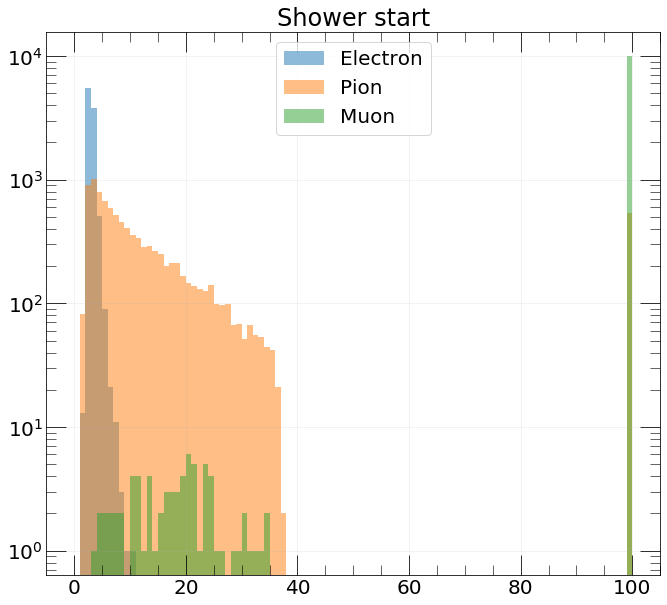

In [226]:
for particle in particletypes:
    plt.hist(data[particle].groupby(level=0).ahc_st.mean(), range=[0,100], bins=100, log=True,
             alpha=0.5, label=particle)
fig1 = plt.gcf()
plt.title("Shower start")
plt.legend(loc='best')
plt.show()

### **Data preprocessing**

As we will see below, one observable is actually already quite enough to build a decent BDT model. Let's preprocess data a bit:

In [205]:
# change event indices to avoid merging of events with same index
data['Pion'].index.set_levels(data['Pion'].index.levels[0]+10000, 
                              level=0,
                              inplace=True)
data['Muon'].index.set_levels(data['Muon'].index.levels[0]+20000, 
                              level=0,
                              inplace=True)

data_merged = pd.concat(data).droplevel(0)

In [206]:
# creating Pandas dataframe on event-by-event basis
X = pd.DataFrame()

X['st'] = data_merged.groupby(level=0).ahc_st.mean()
X['ID'] = data_merged.groupby(level=0).ID.mean() 
features = ['st']
y = data_merged.groupby(level=0).ID.mean()

In [207]:
# split data into train and test samples
X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.5, random_state=42) #50% fraction may be useful to plot distributions for selected events

In [208]:
# loading data into LightGMB format
lgb_train = lgb.Dataset(X_train[features], y_train)
lgb_eval = lgb.Dataset(X_test[features], y_test, reference=lgb_train)

In [234]:
# X.head()
print(X.shape)

(29999, 2)


### **Training model**

In [209]:
# set model parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'softmax',
    'metric': {'multi_logloss'},
    'num_class': 3,
    'max_depth': 10,
    'metric_freq': 1,
    'num_leaves': 10,
    'max_depth' : 10,
    'min_child_samples' : 10,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [210]:
# train the model

# Note: training can also be done with conventional fit() method, smth like this:
# classifier = lgb.LGBMClassifier(n_estimators=100)
# classifier.fit(X_train[features], y_train)

classifier = lgb.LGBMClassifier()
evals_result = {} 
classifier._Booster = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=[lgb_train, lgb_eval],
                evals_result = evals_result,
                early_stopping_rounds=5)
gbm = classifier._Booster

[1]	training's multi_logloss: 0.992525	valid_1's multi_logloss: 0.992163
Training until validation scores don't improve for 5 rounds
[2]	training's multi_logloss: 0.904211	valid_1's multi_logloss: 0.90352
[3]	training's multi_logloss: 0.829663	valid_1's multi_logloss: 0.82869
[4]	training's multi_logloss: 0.766098	valid_1's multi_logloss: 0.764878
[5]	training's multi_logloss: 0.711478	valid_1's multi_logloss: 0.710041
[6]	training's multi_logloss: 0.663848	valid_1's multi_logloss: 0.662216
[7]	training's multi_logloss: 0.622525	valid_1's multi_logloss: 0.620717
[8]	training's multi_logloss: 0.586534	valid_1's multi_logloss: 0.584569
[9]	training's multi_logloss: 0.555088	valid_1's multi_logloss: 0.552982
[10]	training's multi_logloss: 0.527541	valid_1's multi_logloss: 0.525307
[11]	training's multi_logloss: 0.503391	valid_1's multi_logloss: 0.50104
[12]	training's multi_logloss: 0.482138	valid_1's multi_logloss: 0.479681
[13]	training's multi_logloss: 0.463404	valid_1's multi_logloss:

### **Model performance**

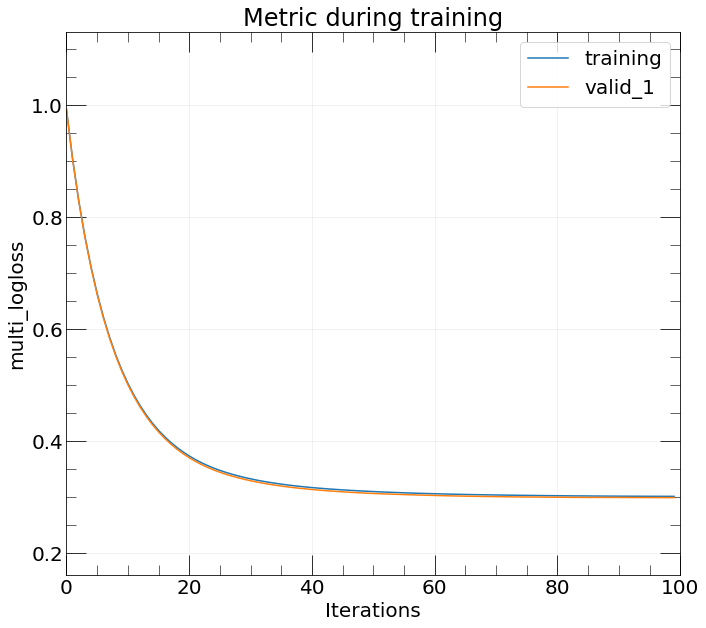

In [211]:
# plot the loss function during training
ax = lgb.plot_metric(evals_result, metric='multi_logloss')
fig1 = plt.gcf()
plt.show()

In [212]:
# make predictions with the model
y_pred = gbm.predict(X_test[features], num_iteration=gbm.best_iteration)

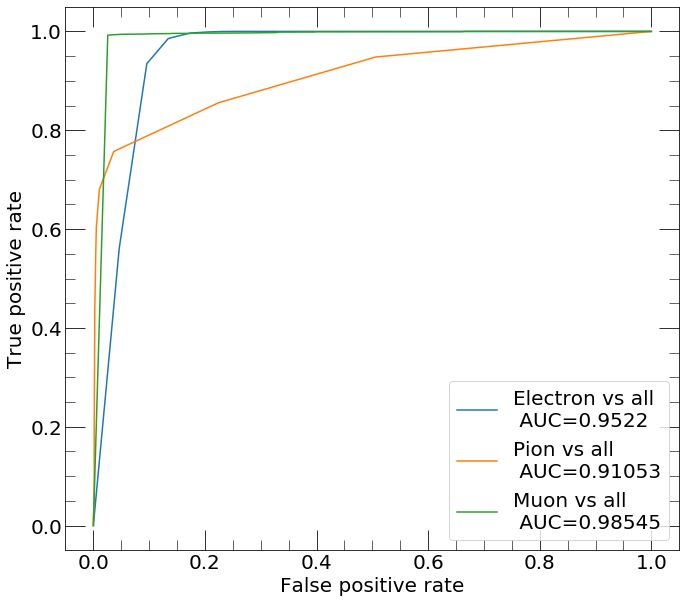

In [213]:
# plot the most interesting ROC curves
for i in range(len(particletypes)):
    tpr, fpr, tres = roc_curve(y_test == i, y_pred[...,i])
    auc = roc_auc_score(y_test == i, y_pred[...,i])
    plt.plot(tpr, fpr, label=particletypes[i] + ' vs all \n AUC='+str(round(auc, 5)))
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
fig1 = plt.gcf()
plt.show()

#### **Exercise 3**

Not bad for only one variable. Here are some questions: 
* Can you explain why is it so?
* What kind of events confuse such model and cause it to mispredict?

In [230]:
# your answer here
print('The model performs good with one variable obtained by thinking of physics!')
print('Sometimes the model can`t tell punch-throug pions from muons, because they do not start the shower or start it too late.')

The model performs good with one variable obtained by thinking of physics!
Sometimes the model can`t tell punch-throug pions from muons, because they do not start the shower or start it too late.


### **Making predictions**

Finally, let's plot the classifier's output (aka score) in categories, which are defined by the maximum output value:

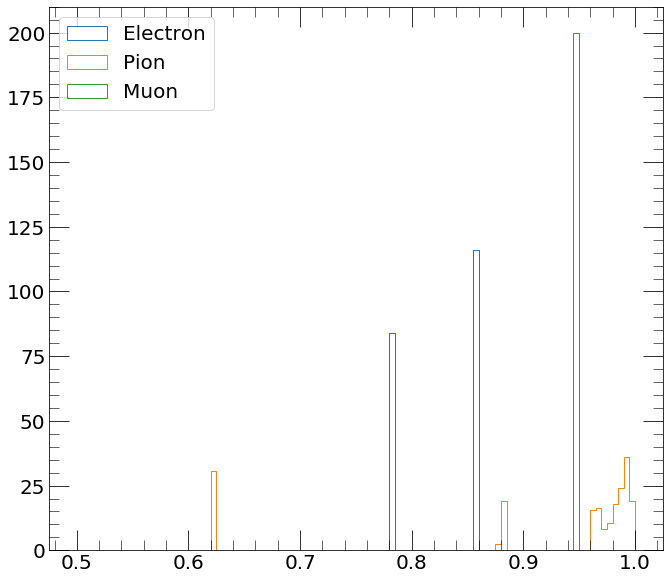

In [231]:
df_pred = pd.DataFrame(y_pred, columns=['e_prob', 'pi_prob', 'mu_prob'])

df_pred['pred_type'] = np.argmax(y_pred, axis=1)
df_pred['pred_prob'] = np.max(y_pred, axis=1)

for i, particle_type in enumerate(particletypes):
    plt.hist(df_pred.query(f'pred_type == {i}').pred_prob, label=particle_type, histtype='step',
             bins=100, range=(0.5, 1.), density=True)
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [21]:
# interesting, isn't it?

### **Saving model**

Model can be saved, e.g in `.txt` format, for the later usage in your analysis group software framework with the corresponding API. 
Also note that some libraries [can save trees in if-else format](https://catboost.ai/docs/features/export-model-to-python.html), but not for the multiclass case.

In [235]:
gbm.save_model("Multiclass_10-200GeV_MC_v2.txt")

### **Homework (main part)**

Good, now we've got the model baseline. There are several ideas how one can improve it: 

1. Create new features
2. Preprocess data in a clever way
3. Tune model hyperparameters 
4. Try other models (e.g. Random Forest, linear models, Neural Nets) 

So now we suggest you to do exactly that: try to beat our baseline! We are very curious to see which tricks and ideas helped you to achieve better performance:)